In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
encoding_style = 'clipped'

In [3]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('../blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

## Model

In [4]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [5]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.reshape((-1, 1)).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [7]:
def conv3x3(in_planes, out_planes, kernel_size=3, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                     padding=kernel_size//2, bias=True)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=1,
                               padding=kernel_size//2, bias=True)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class VariableLengthPooling(nn.Module):
    def forward(self, x, **kwargs):
        bounds = kwargs.get("bounds")
        # print("--------x--------", x.size(), x)
        # print("--------bounds--------", bounds.size(), bounds)
        cnt = torch.sum(bounds, dim=1)
        # print("--------cnt--------", cnt.size(), cnt)
        # print("--------bmm--------", torch.bmm(x, bounds).size(), torch.bmm(x, bounds))
        out = torch.bmm(x, bounds) / cnt
        # print("--------out--------", out.size(), out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "Resnet"
        self.single_alphabet=True
        self.inplanes = 192
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(48, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, x, bounds=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        x = self.conv_merge(x)
        x = torch.squeeze(x, dim=2)
        x = x.view(1, -1)
        
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

class ResNetSeparated(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "ResnetSeparated"
        self.single_alphabet=False
        self.inplanes = 192
        super(ResNetSeparated, self).__init__()
        self.conv1_apt = nn.Conv1d(4, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv1_pep = nn.Conv1d(20, 192, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        #self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        #self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        #self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(96, 1)
        
        self.apt_initial = nn.Sequential(self.conv1_apt, self.bn1, self.relu)
        self.pep_initial = nn.Sequential(self.conv1_pep, self.bn1, self.relu)
        
        

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        
        self.conv_layers = nn.Sequential(self.layer0, self.layer1, self.layer2,
                                         self.conv_merge)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, apt, pep, bounds=None):
        apt = self.apt_initial(apt)
        pep = self.pep_initial(pep)
        
        apt = self.conv_layers(apt)
        pep = self.conv_layers(pep)
        
        apt = torch.squeeze(apt, dim=2)
        pep = torch.squeeze(pep, dim=2)
        
        apt = apt.view(1, -1)
        pep = pep.view(1, -1)
        
        x = torch.cat((apt, pep), 1)
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

In [9]:
# Reinstantiate the model with the proper weights
model = ResNetSeparated(BasicBlock, [1, 1,], num_classes=2)
model_name = model.name
model_id = "08102020"
model.to(device)
checkpointed_model = '../model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
checkpoint = torch.load(checkpointed_model)
optimizer = SGD(model.parameters(), lr=7e-4)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
init_epoch = checkpoint['epoch'] +1
print("Reloading model: ", model.name, " at epoch: ", init_epoch)
model.eval()

<ipython-input-7-634d513fbc57>:210: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight.data)


Reloading model:  ResnetSeparated  at epoch:  50


ResNetSeparated(
  (conv1_apt): Conv1d(4, 192, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_pep): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(192, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(192, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentu

## SGD based search

In [10]:
# Encode the peptide appropriately
def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = translate([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        #pep = blosum62_encoding(pep, seq_type='peptide') Blosum encoding
        pep = one_hot(pep, seq_type='peptide')
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 4, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 20, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=False
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

In [11]:
# Un one-hot the aptamer
def stringify(oh):
    # oh.shape = (1, 4, 40)
    aptamer_string = ""
    na_list = ['A', 'C', 'G', 'T']
    for i in range(40):
        column = oh[0, :, i]
        ind = np.argmax(column)
        aptamer_string += na_list[ind]
    return aptamer_string

In [12]:
# Round the resulting aptamer
def round_aptamer(apt):
    rounded_aptamer = np.zeros((1, 4, 40))
    for i in range(40):
        ind = np.argmax(apt[i, :, :])
        rounded_aptamer[0, ind, i] = 1
    return rounded_aptamer

In [13]:
def perturbed_uniform():
    aptamer_0 = np.full((40, 4), 0.25)
    for i in range(40):
        # Perturb this column 25% of the time
        if random.randint(0, 3) == 1:
            # Find an index to perturb
            inds = random.sample(range(0, 4), 2)
            ind_0 = inds[0]
            ind_1 = inds[1]
            
            # Find an amount to perturb
            amt = random.randint(0, 25)
            amt /= 100
            
            # Transaction
            aptamer_0[i][ind_0] = 0.25 + amt
            aptamer_0[i][ind_1] = 0.25 - amt
    
    return aptamer_0
            

## Use SGD to find an aptamer

In [14]:
def frank_wolfe(peptide, actual_aptamer):
# Initialization with random characters
#     aptamer_0 = ""
#     for i in range(40):
#         aptamer_0 += random.choice(na_list)
#     aptamer_0 = one_hot(aptamer_0, seq_type='aptamer')
    # Initialization with all 0.25
    #aptamer_0 = np.full((40, 4), 0.25)
    
    # Initialization with perturbed all 0s
    aptamer_0 = perturbed_uniform()
    curr_aptamer = aptamer_0
    scores = []
    for k in range(200):
        a, p, l = convert(curr_aptamer, peptide, 1, single_alphabet=False)
        train_score = update(a, p, 1, single_alphabet=False)
        scores.append(train_score.item())
        train_score.backward()
        new_aptamer = np.zeros((40, 4, 1))
        alpha_k = 4/(k + 2)
        for i in range(40):
            # Gradient wrt aptamer
            ind = np.argmax(a.grad[:, :, i].cpu().numpy())
            for j in range(4):
                # new_aptamer.shape = 40, 4, 1
                # curr_aptamer.shape = 1, 4, 40
                new_aptamer[i, j, 0] = (1 - alpha_k)*a[0, j, i] + alpha_k*(j == ind)

        curr_aptamer = new_aptamer
        # Round the aptamer and find the resulting string
    
    rounded_aptamer = round_aptamer(curr_aptamer)
    aptamer_string = stringify(rounded_aptamer)
    
    a, p, l = convert(rounded_aptamer, peptide, 1, single_alphabet=False)
    a = a.permute((2, 1, 0))
    final_score = update(a, p, None, single_alphabet=False)
    #sns.lineplot([i for i in range(len(scores))], scores)
    #plt.show()
    
    # Test the actual aptamer
    actual_aptamer_oh = one_hot(actual_aptamer, seq_type='aptamer')
    a, p, l = convert(actual_aptamer_oh, peptide, 1, single_alphabet=False)
    actual_score = update(a, p, None, single_alphabet=False)
    
    return final_score, actual_score

In [15]:
peptide = "MMFKYRAP"
actual_aptamer = "GCAAAAAGTCTACTTCTCCGTAACGGTAGGATACAGATCG"
frank_wolfe(peptide, actual_aptamer)

(tensor([[0.5473]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.5369]], device='cuda:0', grad_fn=<SigmoidBackward>))

In [16]:
with open('../../data/fw_pairs.txt') as f:
    optimal_count = 0
    unoptimal_count = 0
    found_scores = []
    actual_scores = []
    for i, pair in enumerate(tqdm.tqdm(f.readlines()[:100])):
        apt, pep = pair.split()
        found_score, actual_score = frank_wolfe(pep, apt)
        if found_score >= actual_score:
            optimal_count += 1
        else:
            unoptimal_count += 1
        found_scores.append(found_score)
        actual_scores.append(actual_score)
print("Optimal Found: ", optimal_count)
print("Unoptimal Found: ", unoptimal_count)


100%|██████████| 100/100 [12:25<00:00,  7.46s/it]

Optimal Found:  75
Unoptimal Found:  25


Text(0.5, 1.0, 'Results of the Frank Wolfe Algorithm on 50 items from the higher quality dataset')

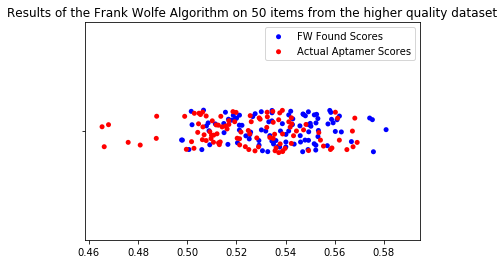

In [17]:
sns.stripplot(found_scores, color='blue', label='FW Found Scores')
sns.stripplot(actual_scores, color='red', label='Actual Aptamer Scores')
plt.legend()
plt.title("Results of the Frank Wolfe Algorithm on 50 items from the higher quality dataset")

## Explore the actual scores for the models

In [25]:
def read_lists(fname):
    actual_scores = []
    with open(fname, "r") as f:
        for val in f:
            val = val.strip()
            val = float(val)
            actual_scores.append(val)
    return actual_scores

In [26]:
resnet_scores = read_lists("RS_actual_scores.txt")
blosumLN_scores = read_lists("BLN_actual_scores.txt")
blosumN_scores = read_lists("BN_actual_scores.txt")

Text(0.5, 1.0, 'Raw scores across models')

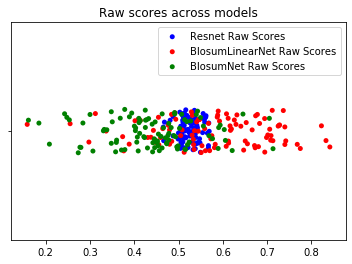

In [27]:
sns.stripplot(resnet_scores, color='blue', label='Resnet Raw Scores')
sns.stripplot(blosumLN_scores, color='red', label='BlosumLinearNet Raw Scores')
sns.stripplot(blosumN_scores, color='green', label='BlosumNet Raw Scores')
plt.legend()
plt.title("Raw scores across models")